# Background Correction Tile Analysis
The example loads a large image on the driver and uses the ```nd_array``` tools to distribute it over many nodes where it can be processed in a tile-based fashion

In [1]:
# standard python tools
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread

In [2]:
# make sure pyqae is available
try:
    import pyqae as pq
except ImportError:
    import sys
    sys.path.append('/Users/mader/Dropbox/Informatics/pyqae-master')
    import pyqae as pq
    
# check to see if it is running on pyspark
try:
    import pyspark
except ImportError:
    print('Using a fake spark backend for processing')
    import pyqae.simplespark as pyspark
    sc = pyspark.LocalSparkContext()

from pyqae.images import viz, pull_img_http_array
import pyqae.nd as nd_array # multidimensional distributed arrays

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'bone'  # change default colormap see plt.cm for other colormap options

/Users/mader/anaconda/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


(30021, 22902)


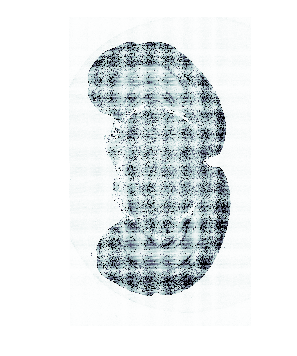

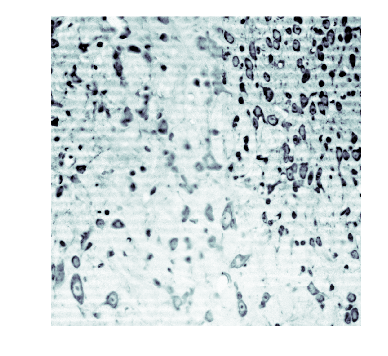

In [3]:
%matplotlib inline
# load an invert the image
brain_stack_img = 255 - imread('/Volumes/ExDisk/cor03639_CH2.tif')
print(brain_stack_img.shape)
_ = viz.show_image(brain_stack_img[::10, ::10])
_ = viz.show_image(brain_stack_img[15000:16000, 10000:11000])

In [11]:
dist_brain_img = nd_array.sp_array(np.expand_dims(np.expand_dims(brain_stack_img,0),3), sc, axis = (0,))
print(dist_brain_img, dist_brain_img.shape)

BoltArray
mode: spark
shape: (1, 30021, 22902, 1)
 (1, 30021, 22902, 1)


In [5]:
from skimage import img_as_float
from skimage.morphology import reconstruction
from skimage.exposure import adjust_gamma
from skimage.filters import gaussian, median, rank

from skimage.morphology import disk

def rolling_ball_background(in_image, radius):
    bg_image = rank.mean(in_image, disk(radius))
    out_image = img_as_float(in_image) - img_as_float(bg_image)
    return out_image
    
def gamma_bg_sub(img, radius = 100, gamma = 0.05):
    img = adjust_gamma(img, gamma)
    img = rolling_ball_background(img, radius)
    return img

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
-0.0588235294118 0.0509803921569
(1502, 1146)


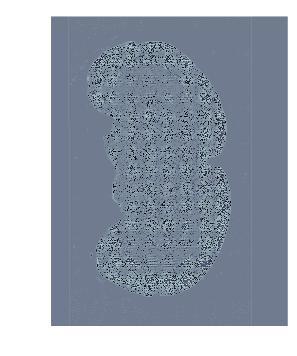

In [8]:
%time
# test on a tiny ROI
cor_img = gamma_bg_sub(brain_stack_img[::25, ::25], radius = 4)
print(cor_img.min(), cor_img.max())
_ = viz.show_image(cor_img, cmap = 'bone', vmin = -0.05, vmax = 0.05)
print(brain_stack_img[::20, ::20].shape)

In [12]:
dist_filt_img = nd_array.filt_tensor(dist_brain_img, filter_op = gamma_bg_sub, tile_size=(1500, 1000), padding = (100, 100))

KeyboardInterrupt: 

In [ ]:
_ = viz.show_image(dist_filt_img[0,::20, ::20, 0].toarray())